In [5]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
#import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)
piyg = cm.get_cmap('PiYG', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

import glob, root_pandas
import uproot3
from scipy.optimize import curve_fit

import misc_util

image_dir = "/home/sebouh/dihadron-analysis-note/images"

def read_n(pattern, n):
    print(n)
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        return b

In [2]:
inb_dihadrons = root_pandas.read_root('/home/sebouh/tuples_hadd/inbend_dihadrons.root')

outb_dihadrons = root_pandas.read_root(glob.glob('/home/sebouh/tuples_hadd/outbend_dihadrons*.root'))

In [6]:
mc = root_pandas.read_root('../in/mc_dihadrons.root')

In [3]:
all_dihadrons = pd.concat([inb_dihadrons,outb_dihadrons])

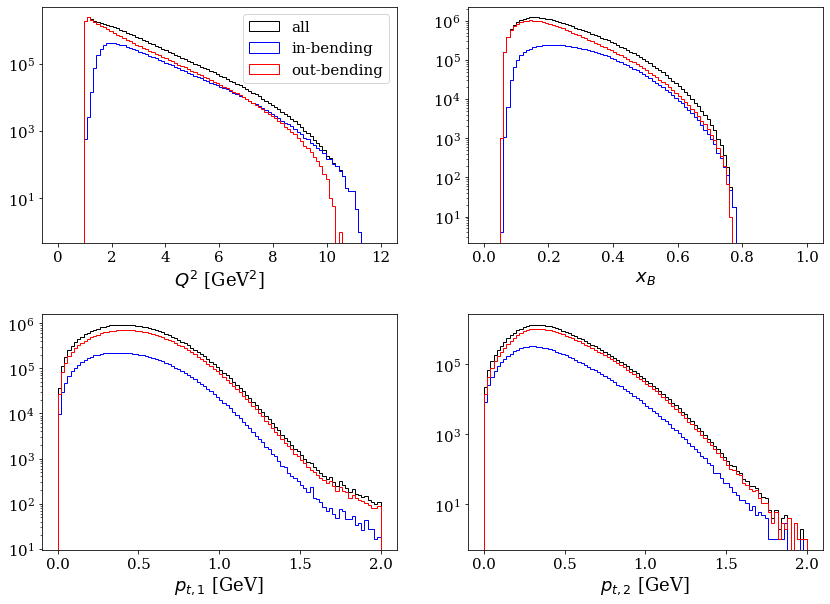

In [23]:
fig,axs = plt.subplots(2,2, figsize=(14,10))
fig.subplots_adjust(hspace=0.3)
variables = [[("Q2",0,12,"$Q^2$ [GeV$^2$]"),("x",0,1,"$x_B$")],
             [("h1_cm_pt",0,2,"$p_{t,1}$ [GeV]"),("h2_cm_pt",0,2,"$p_{t,2}$ [GeV]")]]
dfs = [all_dihadrons,inb_dihadrons,outb_dihadrons]
colors = 'kbr'
labels='all in-bending out-bending'.split()
for i,j in (0,0),(1,0),(0,1),(1,1):
    var = variables[i][j]
    for k in range(3):
        axs[i][j].hist(dfs[k].eval(var[0]),bins=100,histtype='step',color=colors[k],range=var[1:3],label=labels[k])
    axs[i][j].set_xlabel(var[3])
    axs[i][j].set_yscale('log')
axs[0][0].legend()
plt.savefig(image_dir + "/kinematics_inout.pdf", bbox_inches='tight')

In [19]:
labels = r'$\pi^+p$;$\pi^-p$;all $\pi p$;$\pi^+\pi^+$;$\pi^-\pi^+$;$\pi^+\pi^-$;$\pi^-\pi^-$;all $\pi\pi$;all'.split(';')

queries = ['h1_pid==211 and h2_pid==2212','h1_pid==-211 and h2_pid==2212','abs(h1_pid)==211 and h2_pid==2212',
            'h1_pid==211 and h2_pid==211','h1_pid==-211 and h2_pid==211',
            'h1_pid==211 and h2_pid==-211','h1_pid==-211 and h2_pid==-211','abs(h1_pid)==211 and abs(h2_pid)==211', 'h2_pid==h2_pid']
print(r'& $N_{\rm inb}$ & $N_{\rm outb}$ & $N_{\rm tot}$ \\')
for i in range(9):
    Nin = len(inb_dihadrons.query(queries[i]))
    Nout = len(outb_dihadrons.query(queries[i]))
    print(labels[i], Nin, Nout, Nin+Nout, sep=' & ',end='\\\\\n')

& $N_{\rm inb}$ & $N_{\rm outb}$ & $N_{\rm tot}$ \\
$\pi^+p$ & 2108246 & 3617433 & 5725679\\
$\pi^-p$ & 1335832 & 4769188 & 6105020\\
all $\pi p$ & 3444078 & 8386621 & 11830699\\
$\pi^+\pi^+$ & 1015542 & 1061333 & 2076875\\
$\pi^-\pi^+$ & 1196689 & 4442726 & 5639415\\
$\pi^+\pi^-$ & 1070682 & 6746868 & 7817550\\
$\pi^-\pi^-$ & 35661 & 918176 & 953837\\
all $\pi\pi$ & 3318574 & 13169103 & 16487677\\
all & 6828158 & 21732565 & 28560723\\


In [15]:
help(print)

Help on built-in function print in module builtins:

print(...)
    print(value, ..., sep=' ', end='\n', file=sys.stdout, flush=False)
    
    Prints the values to a stream, or to sys.stdout by default.
    Optional keyword arguments:
    file:  a file-like object (stream); defaults to the current sys.stdout.
    sep:   string inserted between values, default a space.
    end:   string appended after the last value, default a newline.
    flush: whether to forcibly flush the stream.



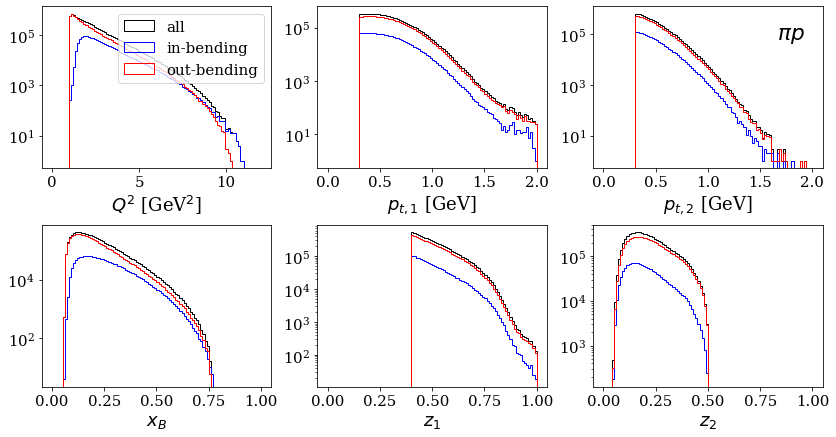

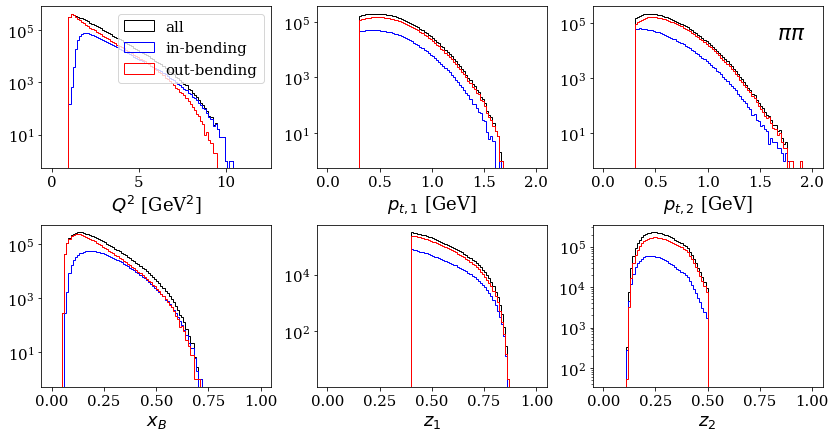

In [4]:
for tag,label, q in ("pi_p","$\pi p$", "abs(h2_pid) == 211 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and abs(h1_pid) ==211 and h2_z < 0.5"),("pi_pi","$\pi\pi$", "h2_pid == 2212 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and mx_eh1x > 1.665 and abs(h1_pid) ==211 and h2_z < 0.5"):
    fig,axs = plt.subplots(2,3, figsize=(14,7))
    fig.subplots_adjust(hspace=0.35)
    variables = [[("Q2",0,12,"$Q^2$ [GeV$^2$]"),("h1_cm_pt",0,2,"$p_{t,1}$ [GeV]"), ("h2_cm_pt",0,2,"$p_{t,2}$ [GeV]")],
                 [("x",0,1,"$x_B$"),("h1_z",0,1,"$z_1$"), ("h2_z",0,1,"$z_2$")]]
    dfs = [df.query(q) for df in [all_dihadrons,inb_dihadrons,outb_dihadrons]]
    colors = 'kbr'
    labels='all in-bending out-bending'.split()
    for i,j in (0,0),(0,1),(0,2),(1,0),(1,1),(1,2):
        var = variables[i][j]
        for k in range(3):
            axs[i][j].hist(dfs[k].eval(var[0]),bins=100,histtype='step',color=colors[k],range=var[1:3],label=labels[k])
        axs[i][j].set_xlabel(var[3])
        axs[i][j].set_yscale('log')
    axs[0][0].legend()
    axs[0][-1].text(0.8, 0.8,label,transform = axs[0][-1].transAxes,fontsize='x-large')
    plt.savefig(image_dir + "/kinematics_inout_%s.pdf" %tag, bbox_inches='tight')

[30, 30, 30]
[30, 30, 30]
[30, 30, 30]
[30, 30, 30]
[30, 30, 30]


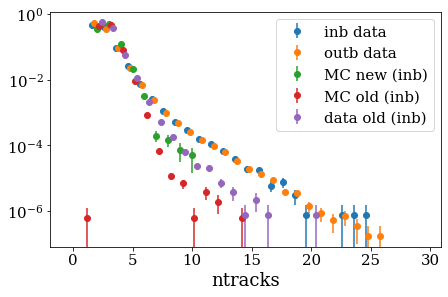

[30, 30, 30]
[30, 30, 30]
[30, 30, 30]
[30, 30, 30]
[30, 30, 30]


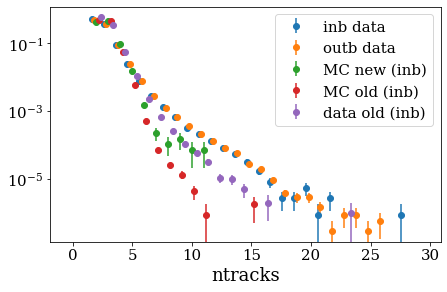

In [45]:
bins=30
mc_new = root_pandas.read_root("../in/mc_test.root",'dihadrons')
data_in_old = root_pandas.read_root("../in/data_dihadrons_100pc.root")
for q,tag in zip(["abs(h2_pid) == 211 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and abs(h1_pid) == 211 and h2_z < 0.5 and nelectrons ==1",
          "h2_pid == 2212 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and mx_eh1x > 1.665 and abs(h1_pid) ==211 and h2_z < 0.5 and nelectrons ==1"],["pi_p","pi_pi"]):

    args = dict(range=(0,bins),bins=bins)

    for df,label,offset in zip([inb_dihadrons.query(q), outb_dihadrons.query(q),mc_new.query(q),mc.query(q),
                               data_in_old.query(q)],
                         ["inb data", "outb data", "MC new (inb)","MC old (inb)","data old (inb)"], [-0.4,-.2,0,.2,0.4]):
        y,x = np.histogram(df.nhtracks, **args)
        y = pd.Series(y)
        x = pd.Series(x[:-1])+offset
        dy = np.sqrt(y)/sum(y)
        y = y/sum(y)
        print([len(a) for a in (x, y, dy)])
        plt.errorbar(x, y,dy,label=label,linestyle='', marker = 'o')
    plt.legend()
    plt.gca().set_xlabel("ntracks")
    plt.gca().set_yscale('log')
    plt.savefig(image_dir+"/ntracks_mc_vs_data_%s.pdf"%tag,bbox_inches='tight')
    plt.show()



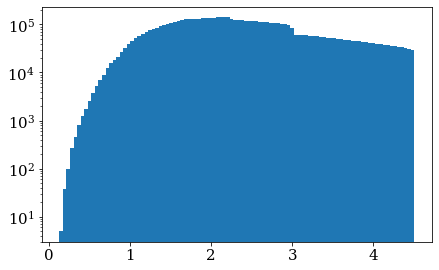

In [47]:
plt.hist(inb_dihadrons.eval("nu/nhtracks"),bins=100)
plt.gca().set_yscale('log')